In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd , eig, inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier   
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor

In [2]:
#files on disk
scores_file = 'full_dataset.csv'
vector_file_i = 'X_i_doc2vec.npy'
vector_file_i_10 = 'X_i_doc2vec_10.npy'

#load files
df = pd.read_csv(scores_file, index_col=0)

X_i = np.load(vector_file_i)
X_i_10 = np.load(vector_file_i_10)

y = df['PHQ8_Binary'].values
y2 = df['PHQ8_Score'].values

In [3]:
print(y.shape)
print(X_i.shape)
print(X_i_10.shape)

(189,)
(189, 100)
(189, 10)


### EDA

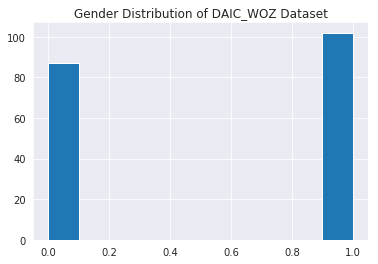

In [4]:
plt.hist(df['Gender'])
plt.title('Gender Distribution of DAIC_WOZ Dataset')
plt.show()

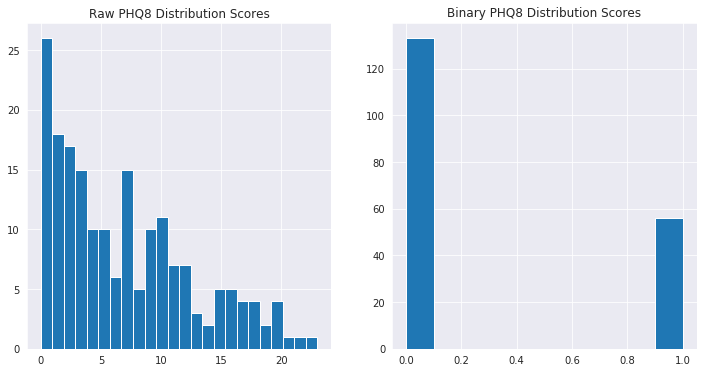

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(df['PHQ8_Score'], bins=24)
ax[0].set_title('Raw PHQ8 Distribution Scores')

ax[1].hist(df['PHQ8_Binary'])
ax[1].set_title('Binary PHQ8 Distribution Scores')

plt.show()

In [6]:
print(np.sum(df['PHQ8_Binary']==0))
print(np.sum(df['PHQ8_Binary']==1))

133
56


Our gender distribution is slightly skewed, but we are more interested in PHQ8 scores. As we can see, the DAIC_WOZ dataset is heavily skewed towards those who score lower on the PHQ8 scale. This could be due to how the binary scores were calculated, although it does seem from the plot on the left of the raw scores that most participants score lower on the PHQ8 scale. This almost 3-1 ratio will need to be taken into account when splitting the data for training. If we are not careful, the splits can miss the "true" distribution of the data, and our models will be biased. In this case, it will be best to use the StratifiedKFold method in scikit-learn when doing cross-validation.

### Training, Classification

Null Hypothesis, H0: there is no difference in the word embeddings created using the transcripts of those who report high feelings of depression and those that don't

Alternative Hypothesis, H1: There is a difference.

In [7]:
"""
classify_and_report() creates lists for accuracy, precision, recall, and fbeta score.
It also creates lists for false positive and true positive rates.
Given a sklearn model, the X and y data sets, it creates stratified k-fold training and test sets.
The model is trained, and then metrics are reported and all lists are returned for further analysis.
"""
def classify_and_report(model, X, y, num):
    
    #for reporting metrics
    accuracy, precision, recall, fbeta = [], [], [], []

    #for roc curve
    fpr, tpr, threshold = [], [], []

    #for confusion matrix
    predictions = []
    ytest = []

    #create splits here
    skf = StratifiedKFold(n_splits=num)
    skf.get_n_splits(X, y)

    #loop over n splits
    for train_idx, test_idx in skf.split(X, y):
        #get subsets of data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
    
        ytest.append(y_test)
    
        #fit and predict on training and test data
        preds = model.fit(X_train, y_train).predict(X_test)
        predictions.append(preds)
    
        #calculate scores and append to lists
        acc = accuracy_score(y_test, preds)
        accuracy.append(acc)
    
        pre = precision_score(y_test, preds)
        precision.append(pre)
    
        rec = recall_score(y_test, preds)
        recall.append(rec)
    
        fb = fbeta_score(y_test, preds, 0.5)
        fbeta.append(fb)
    
        #append false positive rate, true positive rate, and threshold values for roc curve
        fpr_roc, tpr_roc, thresh = roc_curve(y_test, preds)
        fpr.append(fpr_roc)
        tpr.append(tpr_roc)
        threshold.append(thresh)
        
        
    report_metrics_binary(accuracy, precision, recall, fbeta)
        
    return accuracy, precision, recall, fbeta, fpr, tpr, ytest, predictions

In [8]:
"""
This helper method takes in lists of accuracy, precision, recall, and fbeta score.
It then outputs the mean score for each list.
"""
def report_metrics_binary(acc, pre, rec, fb):
    #calculate means of scores for reporting
    mean_accuracy = np.round(np.mean(acc), 4)
    mean_precision = np.round(np.mean(pre), 4)
    mean_recall = np.round(np.mean(rec), 4)
    mean_fbeta = np.round(np.mean(fb), 4)
    
    print('Mean accuracy score: ', mean_accuracy)
    print('Mean precision score: ', mean_precision)
    print('Mean recall score: ', mean_recall)
    print('Mean fbeta score: ', mean_fbeta)

We have already decided to use either the Fbeta score or recall for our purposes. This decision was  made based on trying to reduce our Type 2 errors, where someone identifies as being depressed or scores high on the PHQ8 scale, yet our model misclassifies them. When weighing the other metrics, we think Type 1 errors are more permissable.

In [9]:
"""
Plot accuracy, precision, recall, and fbeta score across k-splits to see how they vary.
"""
def plot_metrics_binary(acc, pre, rec, fb):
    plt.plot(accuracy, label='acc', color='r')

    plt.plot(precision, label='prec', color='g')

    plt.plot(recall, label='rec', color='b')

    plt.plot(fbeta, label='fb', color='purple')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('How Metrics Vary Across Stratified Splits')
    plt.show()

In [10]:
"""
Plot the ROC curve, needs false positive and true positive rate arrays as input.
"""
def plot_roc(fpr, tpr):
    #roc curve
    plt.plot([0, 1], [0, 1], 'k--')

    for i, x in enumerate(fpr):
        plt.plot(fpr[i], tpr[i])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    plt.show()

In [11]:
"""
This method returns the confusion matrix for a given test case.
"""
def plot_cm(ytest, preds, idx):
    cm = confusion_matrix(ytest[idx], preds[idx])
    heatmap = sns.heatmap(cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right', fontsize=12)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for Case {}'.format(idx))
    plt.show()

### Now for the actual training, classification loop

In [12]:
#10-fold split
num = 10

#define classifier models
knn = KNeighborsClassifier(n_neighbors=5)
ada = AdaBoostClassifier()
svm = SVC()

In [13]:
accuracy, precision, recall, fbeta, fpr, tpr, ytest, preds = classify_and_report(knn, X_i, y, num)

Mean accuracy score:  0.6528
Mean precision score:  0.4067
Mean recall score:  0.23
Mean fbeta score:  0.3296


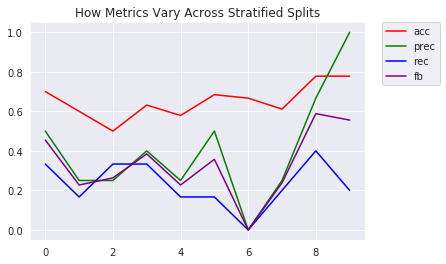

In [14]:
plot_metrics_binary(accuracy, precision, recall, fbeta)

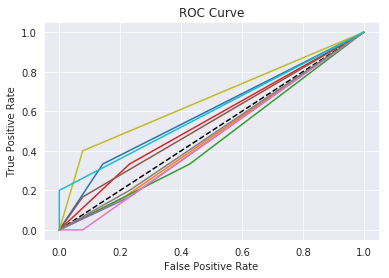

In [15]:
plot_roc(fpr, tpr)

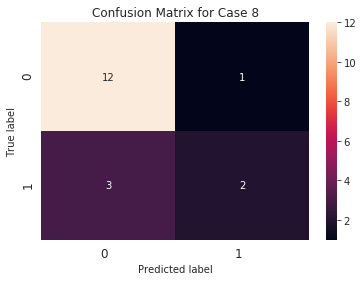

In [16]:
plot_cm(ytest, preds, 8)

### Principal Components Analysis

In [17]:
N = np.shape(X_i)[0]

#create covariance matrix
C = np.matmul(X_i, X_i.T) / N

#eigen alysis on the covariance matrix gives us the EOFs as columns
eigvals, eigvectors = eig(C)

#compute total variance explained by the eigen values
total_eig = np.sum(eigvals)
total_var = eigvals / total_eig

#calculate confidence limits with North et al criterion
delta = total_var * np.sqrt(2 / (N-1))

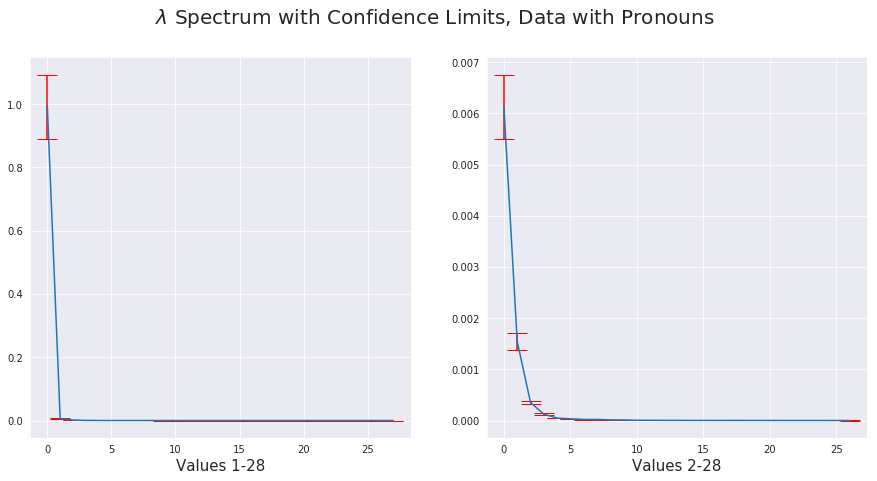

In [18]:
figure, axis = plt.subplots(1, 2, figsize=(15, 7))
axis[0].errorbar(np.arange(0, 28), total_var[:28], yerr=delta[:28], ecolor='r', capsize=10)
axis[1].errorbar(np.arange(0, 27), total_var[1:28], yerr=delta[1:28], ecolor='r', capsize=10)
axis[0].set_title('')
axis[1].set_title('')

figure.suptitle('$\lambda$ Spectrum with Confidence Limits, Data with Pronouns', fontsize=20)
axis[0].set_xlabel('Values 1-28', fontsize=15)
axis[1].set_xlabel('Values 2-28', fontsize=15)

plt.show()

In [19]:
#amount of variance explained by the first 5 eofs
print([np.round(float(var), 6) for var in total_var[:4]])

[0.991541, 0.006126, 0.001548, 0.000353]


The first four EOFs are independent, but the first EOF makes up almost 100% of the variance.

In [20]:
#try to classify with only the first EOF
X_eof = np.reshape(eigvectors[:, 0], (-1, 1))

accuracy, precision, recall, fbeta, fpr, tpr, ytest, preds = classify_and_report(knn, X_eof, y, num)

Mean accuracy score:  0.6184
Mean precision score:  0.325
Mean recall score:  0.1767
Mean fbeta score:  0.2613


/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


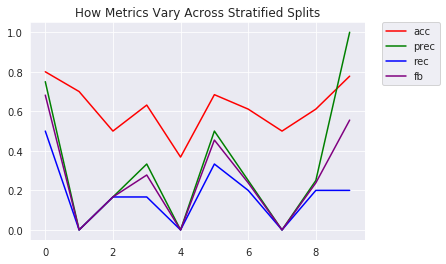

In [21]:
plot_metrics_binary(accuracy, precision, recall, fbeta)

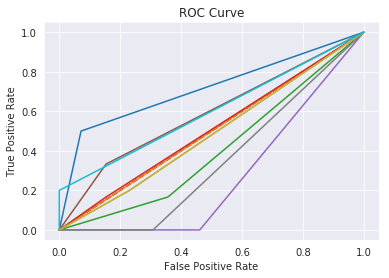

In [22]:
plot_roc(fpr, tpr)

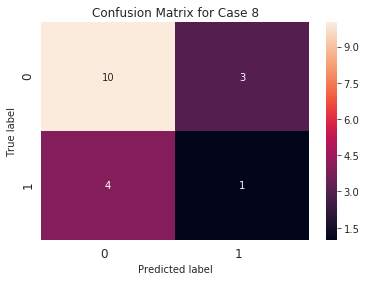

In [23]:
plot_cm(ytest, preds, 8)

In the case of classification, PCA doesn't have a big effect on performance.

### Try Regression Case

In [24]:
"""
regress_and_report() creates lists for root mean squared error and r2 score.
Given a sklearn model, the X and y data sets, it creates stratified k-fold training and test sets.
The model is trained, and then metrics are reported and all lists are returned for further analysis.
"""
def regress_and_report(model, X, y, num):
    
    #for reporting metrics
    mse, r2 = [], []

    #for confusion matrix
    predictions = []
    ytest = []

    #create splits here
    skf = StratifiedKFold(n_splits=num)
    skf.get_n_splits(X, y)

    #loop over n splits
    for train_idx, test_idx in skf.split(X, y):
        #get subsets of data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
    
        ytest.append(y_test)
    
        #fit and predict on training and test data
        preds = model.fit(X_train, y_train).predict(X_test)
        predictions.append(preds)
    
        #calculate scores and append to lists
        mse_ = mean_squared_error(y_test, preds)
        mse.append(mse_)
    
        r2_ = r2_score(y_test, preds)
        r2.append(r2_)
        
    
    rmse = np.sqrt(mse)
    
    report_metrics_regress(rmse, r2)
        
    return rmse, r2, ytest, predictions

In [25]:
"""
This helper method takes in lists of root mean squared error and r2 score
It then outputs the mean score for each list.
"""
def report_metrics_regress(rmse, r2):
    #calculate means of scores for reporting
    mean_rmse = np.round(np.mean(rmse), 4)
    mean_r2 = np.round(np.mean(r2), 4)
    
    print('Mean rmse score: ', mean_rmse)
    print('Mean r2 score: ', mean_r2)

In [26]:
"""
Plot root mean squared error and r2 score score across k-splits to see how they vary.
"""
def plot_metrics_regress(rmse):
    plt.plot(rmse, label='rmse', color='r')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('How Regression Metrics Vary Across Stratified Splits')
    
    plt.xlabel('Split Number K')
    plt.ylabel('Root Mean Squared Error')

    plt.show()

In [27]:
#define regression models
lr = LinearRegression()
sgd = SGDRegressor(max_iter=100, tol=1e-3)
forest = RandomForestRegressor(n_estimators=10)
ridge = Ridge()

In [28]:
rmse, r2, ytest, preds = regress_and_report(ridge, X_i_10, y2, num)

Mean rmse score:  5.4142
Mean r2 score:  -0.2599


/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


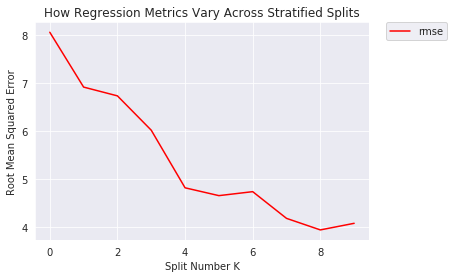

In [29]:
plot_metrics_regress(rmse)

#plt.savefig('metrics_regression_ridge.pdf', format='pdf', bbox_inches='tight')

In [30]:
print(ytest[-2], '\n')
print(preds[-2])

[10  5  9  0  4  3  7  1  2  0] 

[6.265778  7.004522  9.180451  6.3256955 5.9172893 5.8735323 5.834468
 5.677019  6.9290357 6.181321 ]


### PCA, with regression

In [31]:
rmse, r2, ytest, preds = regress_and_report(sgd, X_eof, y2, num)

Mean rmse score:  5.4502
Mean r2 score:  -0.3162


/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


On a scoring system between 0-24, getting as low as 4 points away is not bad. These questions remain: can we reduce this error closer to zero, and where does the error take place (are we correctly classifying those with scores >= 15 more often than not?)? As we can see from the printout above, our model is outputting mainly in the range of 5 <= x <= 10, which is not ideal. However, a neural network may be able to reduce this error through training.